In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm

In [2]:
# clean data
data = pd.read_csv('spx_iv.csv')
tem = list(data.columns)
tem[3:26] = map(lambda x:x.split(' ')[3], tem[3:26])
tem[28:41] = map(lambda x:x.split(' ')[3], tem[28:41])
tem[41:63] = map(lambda x:x.split(' ')[3]+'_IV', tem[41:63])
tem[63:77] = map(lambda x:x.split(' ')[3]+'_IV', tem[63:77])
data.columns = tem
data.Dates = pd.to_datetime(data.Dates)
data.index = data.Dates
data.head()

,Dates,SPX,VIX,C2500,C2600,C2700,C2800,C2850,C2900,C3000,...,C3025_IV,C3050_IV,C3075_IV,P2850_IV,P2925_IV,P2950_IV,P2975_IV,P3025_IV,P3050_IV,P3075_IV
Dates,,,,,,,,,,,,,,,,,,,,,
2019-09-02,2019-09-02,2926.46,18.98,432.05,310.55,231.85,191.25,157.45,120.4,63.60,...,14.351,13.959,13.371,18.480,16.814,16.142,15.628,14.163,13.802,13.393
2019-09-03,2019-09-03,2906.27,19.66,432.05,310.55,260.00,191.25,148.80,113.7,57.40,...,14.351,14.040,13.649,18.934,17.039,16.512,15.628,14.163,14.172,13.393
2019-09-04,2019-09-04,2937.78,17.33,432.05,310.55,260.00,193.71,161.00,128.1,66.70,...,14.278,13.645,13.183,18.528,16.636,16.162,15.505,14.499,14.172,13.153
2019-09-05,2019-09-05,2976.00,16.27,494.68,402.00,260.00,230.00,187.80,153.5,83.75,...,14.111,13.567,13.085,18.173,16.614,15.788,15.336,14.420,13.668,13.647
2019-09-06,2019-09-06,2978.71,15.00,494.68,396.60,313.45,230.00,190.80,152.8,82.15,...,13.860,13.217,12.938,18.086,16.410,15.543,14.997,14.420,13.367,13.647


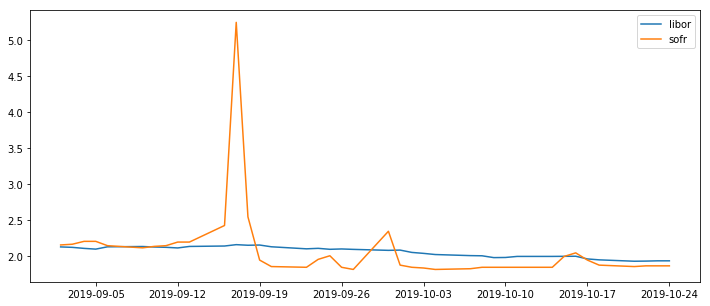

In [3]:
# using SPFR to replace LIBOR
# Why SOFR increased by 2.5% on Sept 17th?
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(data.LIBOR, label = 'libor')
plt.plot(data.SOFR, label = 'sofr')
plt.legend()
plt.show()

<img src="https://tva1.sinaimg.cn/large/006y8mN6gy1g85d5sj45xj30ti0fq75r.jpg" width = "45%" />

----
- BSM Formula

<img src="https://tva1.sinaimg.cn/large/006y8mN6gy1g85derir5uj30x20lggnb.jpg" width = "55%" />

In [4]:
# using BSM calculate price(theoretical) and vega
def BSM(s,k,t,r,sigma,cp):
    d1 = (log(s/k) + (r+0.5*sigma**2)*t) / (sigma*sqrt(t))
    d2 = d1 - sigma*sqrt(t)
    # BSM vega (1st patial derivative of BSM with the respect of sigma), using for Newton's method
    vega = s*sqrt(t) * norm.cdf(d1,0,1)
    # BSM price
    if cp == 'C': # Call
        call = s*norm.cdf(d1,0,1) - k*exp(-r*t) * norm.cdf(d2,0,1)
        return call, vega
    elif cp == 'P':
        put = k*exp(-r*t) * norm.cdf(-d2,0,1) - s*norm.cdf(-d1,0,1)
        return put, vega
    

# Newton's method: x_n+1 = x_n - f(x_n)/f'(x_n)
# calculate implied volatility
def IV(date, option):  # option means the name of the option, string
    t = (pd.to_datetime('2019/12/20') - pd.to_datetime(date)).days/365  # day to mature
    tem = data.loc[data.Dates == date]
    mkt_p = tem[option].values[0]  # market price
    k = float(option[1:])  # strike price
    cp = option[0] # call or put
    r = tem['SOFR'].values[0]/100  # SOFR
    s = tem['SPX'].values[0]  # underlying (SPX)
    sigma = 0.2  # initial sigma

    bsm_p, vega = BSM(s,k,t,r,sigma,cp)
    sigma_pre = sigma
    sigma = sigma_pre - (mkt_p - bsm_p)/(-1*vega)
    while abs(sigma - sigma_pre) > 0.0005:  
        sigma_pre = sigma
        bsm_p, vega = BSM(s,k,t,r,sigma,cp)
        sigma = sigma_pre - 0.5*(mkt_p - bsm_p)/(-1*vega)  # Newton's method
    print("IV of {a} is {b:5.4f}, which on bloomberg is {c:5.4f}".format(a=option, b=sigma, c=tem[option+'_IV'].values[0]/100))
    return sigma

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


IV of C2500 is   nan, which on bloomberg is 0.2501
IV of C2600 is 0.1510, which on bloomberg is 0.2192
IV of C2700 is 0.1468, which on bloomberg is 0.2015
IV of C2800 is 0.1659, which on bloomberg is 0.1801
IV of C2850 is 0.1297, which on bloomberg is 0.1706
IV of C2900 is 0.1445, which on bloomberg is 0.1584
IV of C2925 is 0.1518, which on bloomberg is 0.1523
IV of C2950 is 0.1330, which on bloomberg is 0.1442
IV of C2975 is 0.1253, which on bloomberg is 0.1378
IV of C3000 is 0.1220, which on bloomberg is 0.1319
IV of C3025 is 0.1139, which on bloomberg is 0.1234
IV of C3050 is 0.1085, which on bloomberg is 0.1170
IV of C3075 is 0.1036, which on bloomberg is 0.1113
IV of C3100 is 0.1016, which on bloomberg is 0.1057
IV of C3200 is 0.0965, which on bloomberg is 0.1002
IV of C3300 is 0.1051, which on bloomberg is 0.1074
IV of C3400 is 0.1140, which on bloomberg is 0.1146
IV of C3500 is 0.1258, which on bloomberg is 0.1287
IV of P2500 is 0.2300, which on bloomberg is 0.2420
IV of P2600 i

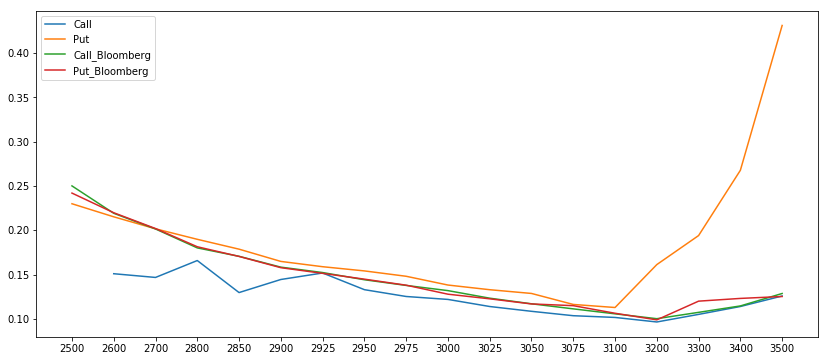

In [5]:
date = '2019/10/17'
clist = ['C2500', 'C2600', 'C2700', 'C2800', 'C2850', 'C2900', 'C2925', 'C2950', 'C2975', 'C3000', 'C3025',
        'C3050', 'C3075', 'C3100', 'C3200', 'C3300', 'C3400', 'C3500']
plist = ['P2500', 'P2600', 'P2700', 'P2800', 'P2850', 'P2900',  'P2925', 'P2950', 'P2975', 'P3000', 'P3025',
        'P3050','P3075', 'P3100', 'P3200', 'P3300', 'P3400', 'P3500',]
result = pd.DataFrame(np.matrix([[0]*len(clist)]*4))
result.columns = map(lambda x:x[1:], clist)
tem = [0 for i in range(len(clist))]

# calculate IV
for i in range(len(clist)):
    tem[i] = IV(date,clist[i])
result.iloc[0,:] = tem
for i in range(len(plist)):
    tem[i] = IV(date,plist[i])
result.iloc[1,:] = tem

# IV on bloomberg
for i in range(len(clist)):
    tem[i] = data.loc[data.Dates == date][clist[i]+'_IV'].values[0]/100
result.iloc[2,:] = tem
for i in range(len(plist)):
    tem[i] = data.loc[data.Dates == date][plist[i]+'_IV'].values[0]/100
result.iloc[3,:] = tem

f, ax = plt.subplots(figsize=(14, 6))
plt.plot(result.iloc[0,:], label = 'Call')
plt.plot(result.iloc[1,:], label = 'Put')
plt.plot(result.iloc[2,:], label = 'Call_Bloomberg')
plt.plot(result.iloc[3,:], label = 'Put_Bloomberg')
plt.legend()
plt.show()

In [6]:
tem = ['C2500','C2600','C2700','C3300','C3400','C3500','P2500','P2600','P2700','P3300','P3400','P3500']
for i in tem:
    print("in {a} days, there are {b} unique prices in {c}".format(a=len(data), b=len(data[i].unique()), c=i))

in 39 days, there are 18 unique prices in C2500
in 39 days, there are 16 unique prices in C2600
in 39 days, there are 20 unique prices in C2700
in 39 days, there are 30 unique prices in C3300
in 39 days, there are 17 unique prices in C3400
in 39 days, there are 9 unique prices in C3500
in 39 days, there are 38 unique prices in P2500
in 39 days, there are 38 unique prices in P2600
in 39 days, there are 37 unique prices in P2700
in 39 days, there are 15 unique prices in P3300
in 39 days, there are 7 unique prices in P3400
in 39 days, there are 10 unique prices in P3500
